# 导入依赖和数据

In [11]:
import pandas as pd
import backtrader as bt
import yfinance as yf
import matplotlib.pyplot as plt

In [12]:
dt = yf.Ticker('AAPL')
dt_hist = dt.history(period='5y', auto_adjust=True, repair=True)
dt_hist.drop(columns=['Dividends', 'Stock Splits', 'Repaired?'], inplace=True)
dt_hist.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-08-24 00:00:00-04:00,125.186359,125.271480,120.556227,122.423843,345937600
2020-08-25 00:00:00-04:00,121.295486,121.764820,119.695361,121.419502,211495600
2020-08-26 00:00:00-04:00,122.737539,123.527873,121.669978,123.070694,163022400
2020-08-27 00:00:00-04:00,123.673769,124.006924,120.454069,121.599449,155552400
2020-08-28 00:00:00-04:00,122.574600,122.992869,121.178753,121.402481,187630000


# 定义策略（RSI）
- 周期选择14个交易日

In [13]:
class RSI_Strategy(bt.Strategy):
    params = (
        ('rsi_period', 14), 
        ('oversold', 30),  # 超卖区
        ('overbought', 70)  # 超买区
    )
    def __init__(self):
        self.order = None
        self.buy_price = None
        self.comm = None
        self.dataclose = self.datas[0].close
        self.rsi = bt.indicators.RSI_EMA(
            self.dataclose, 
            period=self.p.rsi_period
        )

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 如果订单是完成状态 (买入/卖出)
        if order.status in [order.Completed]:
            if order.isbuy():
                self.buyprice = order.executed.price
                self.comm = order.executed.comm
                print(f"买入执行 - 日期: {self.data.datetime.date()}, 价格: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 佣金: {order.executed.comm:.2f} \n ----")
            elif order.issell():
                print(f"卖出执行 - 日期: {self.data.datetime.date()}, 价格: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 佣金: {order.executed.comm:.2f} \n ----")
            self.bar_executed = len(self) # 记录订单执行时的 bar 数量
        # 如果订单是取消、保证金不足、拒绝等状态
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print(f"订单状态: {order.Status[order.status]} - 日期: {self.data.datetime.date()}")
        self.order = None

    def notify_trade(self, trade):
        # 交易完成（平仓）时调用
        if not trade.isclosed:
            return
        print(f"交易完成 - 毛利润: {trade.pnl:.2f}, 净利润: {trade.pnlcomm:.2f} \n ========")

    def next(self):
        current_rsi = self.rsi[0]
        current_close = self.dataclose[0]
        # ====买入信号====
        if not self.position:
            if current_rsi < self.p.oversold:
                self.order = self.buy(size=10)
                print(f"======== \n 发出买入信号 - 日期：{self.data.datetime.date()}, 收盘：{current_close:.2f}, RSI：{current_rsi:.2f}")
        # ====卖出信号====
        else:
            if current_rsi > self.p.overbought:
                self.order = self.close()
                print(f"发出卖出信号 - 日期：{self.data.datetime.date()}, 收盘：{current_close:.2f}, RSI：{current_rsi:.2f}")

        # ====特殊情况====
        if self.p.rsi_period > len(self):
            return
        if self.order is not None:
            return

# 策略实例化
- **indicators**:  
- 收益率
- 夏普比率
- 胜率比
- 盈亏比
- 最大回撤

In [14]:
cerebro = bt.Cerebro()
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer,  _name='trade_anlyzr')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharp_anlyzr')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='draw_anlyzr')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns_anlyzr', timeframe=bt.TimeFrame.Days)

# 导入数据
data = bt.feeds.PandasData(
    dataname=dt_hist,
    timeframe=bt.TimeFrame.Days
)
cerebro.adddata(data)
cerebro.addstrategy(RSI_Strategy)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.0006)

# 运行策略
print(f"初始资金: {cerebro.broker.getvalue():.2f}")
resuluts = cerebro.run()
thestrat = resuluts[0]
trade_analyzer = thestrat.analyzers.trade_anlyzr.get_analysis()
return_analyzer = thestrat.analyzers.returns_anlyzr.get_analysis()
sharp_analyzer = thestrat.analyzers.sharp_anlyzr.get_analysis()
draw_analyzer = thestrat.analyzers.draw_anlyzr.get_analysis()
print(f"最终资金为：{cerebro.broker.getvalue():.2f}")
print(f"总收益率为：{return_analyzer.get('rtot', 0) * 100:.2f}%")
print(f"夏普比率为：{sharp_analyzer['sharperatio']:.4f}")

total_trades = trade_analyzer.total.closed
winning_trades = trade_analyzer.won.total
win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0
print(f"胜率比为：{winning_trades}/{total_trades}，{win_rate:.2f}%")

gross_profit = trade_analyzer.won.pnl.total
gross_loss = abs(trade_analyzer.lost.pnl.total)
profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')
print(f"盈亏比为：{profit_factor:.2f}")
print(f"最大回撤为：{draw_analyzer.max.drawdown:.2f}%")

初始资金: 100000.00
 发出买入信号 - 日期：2020-09-18, 收盘：103.93, RSI：26.18
买入执行 - 日期: 2020-09-21, 价格: 101.69, 成本: 1016.88, 佣金: 0.61 
 ----
发出卖出信号 - 日期：2020-10-12, 收盘：121.01, RSI：71.93
卖出执行 - 日期: 2020-10-13, 价格: 121.85, 成本: 1016.88, 佣金: 0.73 
 ----
交易完成 - 毛利润: 201.64, 净利润: 200.30 
 发出买入信号 - 日期：2021-02-18, 收盘：126.58, RSI：28.07
买入执行 - 日期: 2021-02-19, 价格: 127.09, 成本: 1270.95, 佣金: 0.76 
 ----
发出卖出信号 - 日期：2021-04-07, 收盘：124.81, RSI：71.33
卖出执行 - 日期: 2021-04-08, 价格: 125.84, 成本: 1270.95, 佣金: 0.76 
 ----
交易完成 - 毛利润: -12.59, 净利润: -14.11 
 发出买入信号 - 日期：2021-05-12, 收盘：120.01, RSI：23.85
买入执行 - 日期: 2021-05-13, 价格: 121.78, 成本: 1217.78, 佣金: 0.73 
 ----
发出卖出信号 - 日期：2021-06-14, 收盘：127.55, RSI：71.64
卖出执行 - 日期: 2021-06-15, 价格: 127.02, 成本: 1217.78, 佣金: 0.76 
 ----
交易完成 - 毛利润: 52.39, 净利润: 50.90 
 发出买入信号 - 日期：2021-09-20, 收盘：139.93, RSI：23.86
买入执行 - 日期: 2021-09-21, 价格: 140.90, 成本: 1409.04, 佣金: 0.85 
 ----
发出卖出信号 - 日期：2021-10-19, 收盘：145.63, RSI：72.32
卖出执行 - 日期: 2021-10-20, 价格: 145.57, 成本: 1409.04, 佣金: 0.87 
 ----
交易完成 - 毛利润:

<IPython.core.display.Javascript object>

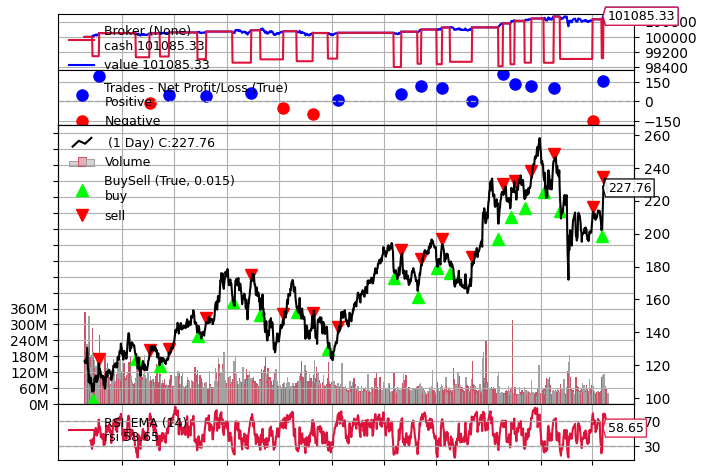

In [15]:
%matplotlib inline
cerebro.plot()[0][0]